In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import transforms
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import torch.nn as nn
import torch.nn.functional as F
import os
import random

## Analiza okolje-specifičnih podatkov iz naključne slike

#### Razreda modelov

In [2]:
class WeatherCNN(nn.Module):
    def __init__(self):
        super(WeatherCNN, self).__init__()

        # Dve konvolucijske plasti
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)

        # Popolnoma povezana/Fully connected plast
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 3)  # Izhod zdaj 3 oznake, pri TimeOfDay 2

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
class TimeOfDayCNN(nn.Module):
    def __init__(self):
        super(TimeOfDayCNN, self).__init__()

        # Dve konvolucijske plasti
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)

        # Popolnoma povezana/Fully connected plast
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 2)
        
    def forward(self, x): # Pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [16]:
daynight_model = TimeOfDayCNN()
weather_model = WeatherCNN()

daynight_weights = torch.load("Models/model_daynight.pth", map_location='cpu', weights_only=True)
weather_weights = torch.load("Models/model_weather.pth", map_location='cpu', weights_only=True)

daynight_model.load_state_dict(daynight_weights)
weather_model.load_state_dict(weather_weights)

daynight_model.eval()
weather_model.eval()

WeatherCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [17]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# test_dataset = datasets.ImageFolder("Podatki_split/", transform=transform)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Oznake za mapiranje
timeofday_labels = ['day', 'night']
weather_labels = ['clear', 'foggy', 'rainy']

test_dir = "Data/Podatki_test"
image_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

In [18]:
def simulate_car_behavior(time_label, weather_label):
    actions = []

    if time_label == 'night':
        actions.append("Vklop - Vklop zasenčenih (ali dolgih) žarometov.")
        actions.append("Vklop - Ambiente svetlobe.")
        actions.append("Zatemnitev - Armaturne plošče in zaslona")
        actions.append("Opozorilo - Če je slaba vidljivost zmanjšaj hitrost!")
    else:
        actions.append("Vklop - Dnevnih luči")

    if weather_label == 'rainy':
        actions.append("Vklop - Brisalcev vetrobranskega stekla")
        actions.append("Vklop - Gretje stekel in ogledal")
        actions.append("Opozorilo - Zmanjšaj hitrost!")
    elif weather_label == 'foggy':
        actions.append("Vklop - Meglenk (sprednjih in zadnjih)")
        actions.append("Opozorilo - Zmanjšaj hitrost!")
    else:
        actions.append("Jasno vreme: Priporočena normalna vožnja")

    return actions

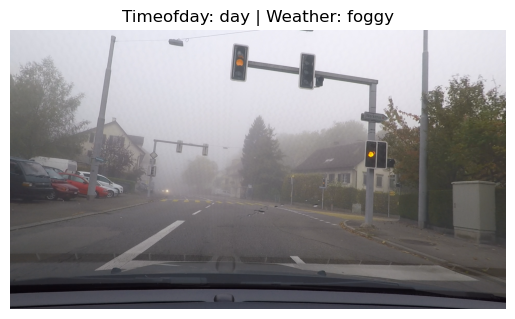

Stanje okolja: foggy day
🚗 Vklop - Dnevnih luči
🚗 Vklop - Meglenk (sprednjih in zadnjih)
🚗 Opozorilo - Zmanjšaj hitrost!


In [22]:
random_img = random.choice(image_files)
img_path = os.path.join(test_dir, random_img)

image = Image.open(img_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0)

# Izbrano random sliko čez oba modela
with torch.no_grad():
    pred_dn = torch.argmax(daynight_model(input_tensor), dim=1).item()
    pred_wt = torch.argmax(weather_model(input_tensor), dim=1).item()

# Prikaz rezultata
plt.imshow(image)
plt.axis('off')
plt.title(f"Timeofday: {timeofday_labels[pred_dn]} | Weather: {weather_labels[pred_wt]}")
plt.show()

actions = simulate_car_behavior(timeofday_labels[pred_dn], weather_labels[pred_wt])

print(f"Stanje okolja: {weather_labels[pred_wt]} {timeofday_labels[pred_dn]}")
for action in actions:
    print("🚗", action)

## Testiranje nad množico testnih podatkov/Statistike

In [8]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [10]:
timeofday_test_dataset = ImageFolder(root='Data/Podatki_split/timeofday/test', transform=transform)
weather_test_dataset = ImageFolder(root='Data/Podatki_split/weather/test', transform=transform)

batch_size = 32

timeofday_test_loader = DataLoader(timeofday_test_dataset, batch_size=batch_size, shuffle=False)
weather_test_loader = DataLoader(weather_test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
import torch
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Evaluacija

In [12]:
def evaluate_model(model, dataloader, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    
    return acc, cm

Day/Night Test Accuracy: 0.9826
Weather Test Accuracy: 0.9680


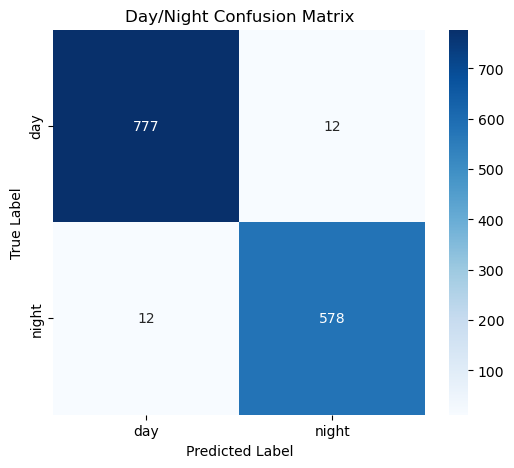

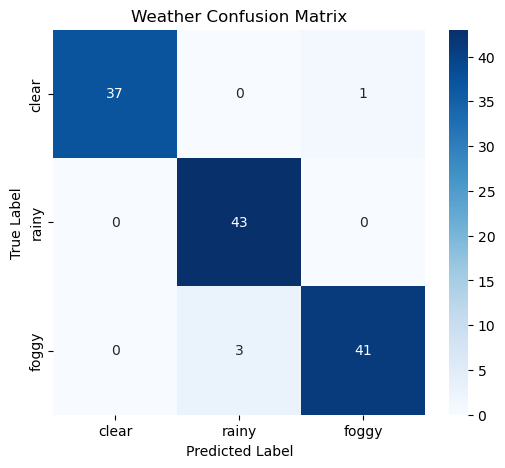

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
daynight_model.to(device)
weather_model.to(device)

acc_dn, cm_dn = evaluate_model(daynight_model, timeofday_test_loader, device=device)
acc_wt, cm_wt = evaluate_model(weather_model, weather_test_loader, device=device)

print(f"Day/Night Test Accuracy: {acc_dn:.4f}")
print(f"Weather Test Accuracy: {acc_wt:.4f}")

def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.show()

timeofday_labels = ['day', 'night']
weather_labels = ['clear', 'rainy', 'foggy']

plot_confusion_matrix(cm_dn, timeofday_labels, 'Day/Night Confusion Matrix')
plot_confusion_matrix(cm_wt, weather_labels, 'Weather Confusion Matrix')